# Operations on the image data

## Load the dataset

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
from scivision.io import load_dataset

In [2]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels = cat.labels().read()

labels_dedup = xr.Dataset.from_dataframe(
    labels
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

Smaller subset for convenience:

In [3]:
rng = np.random.default_rng()
ds_subset = ds_labelled.sel(
    concat_dim=rng.choice(ds_labelled.concat_dim, size=2000, replace=False)
)

ds_subset.load()

<xarray.Dataset>
Dimensions:                               (concat_dim: 2000, y: 832, x: 1040, channel: 3)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2020-10-1...
  * concat_dim                            (concat_dim) int64 32530 ... 57082
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 2...
    EXIF Image ImageWidth                 (concat_dim) object 64 64 72 ... 64 72
    EXIF Image ImageLength                (concat_dim) object 66 58 74 ... 60 60
    EXIF Image BitsPerSample              (concat_dim) object [8, 8, 8] ... [...
    EXIF Image Compression                (concat_dim) object Uncompressed .....
    EXIF Image PhotometricInterpretation  (concat_dim) object 2 2 2 2 ... 2 2 2
    ...                                    ...
    EXIF GPS GPSLongitude                 (concat_dim) object [4, 143651/1000...
    EXIF Image GPSInfo                    (concat_dim) object 236 236 ... 236
    index                                 (concat_dim) int64 32578 ... 57130
    label1                                (concat_dim) object 'detritus' ... ...
    label2                                (concat_dim) object 'detritus' ... ...
    label3                                (concat_dim) object 'detritus' ... ...

## Image size

In [4]:
ds_subset = ds_subset.assign(
    image_width = ds_subset['EXIF Image ImageWidth'].to_pandas().apply(lambda x: x.values[0]),
    image_length = ds_subset['EXIF Image ImageLength'].to_pandas().apply(lambda x: x.values[0])
)

In [5]:
ds_subset.image_width.min(), ds_subset.image_width.max()

(<xarray.DataArray 'image_width' ()>
 array(40),
 <xarray.DataArray 'image_width' ()>
 array(704))

In [6]:
ds_subset.image_length.min(), ds_subset.image_length.max()

(<xarray.DataArray 'image_length' ()>
 array(58),
 <xarray.DataArray 'image_length' ()>
 array(792))

In [7]:
print(ds_subset.isel(concat_dim=ds_subset.image_width.argmax()))

<xarray.Dataset>
Dimensions:                               (y: 832, x: 1040, channel: 3)
Coordinates:
    filename                              object 'Pia1.2016-10-12.0004+N4623_...
    concat_dim                            int64 282
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/29)
    raster                                (y, x, channel) uint8 187 183 ... 0 0
    EXIF Image ImageWidth                 object 704
    EXIF Image ImageLength                object 502
    EXIF Image BitsPerSample              object [8, 8, 8]
    EXIF Image Compression                object Uncompressed
    EXIF Image PhotometricInterpretation  object 2
    ...                                    ...
    index                                 int64 14316
    label1                                object 'zooplankt

In [8]:
one_image = ds_subset.isel(concat_dim=ds_subset.image_width.argmax())

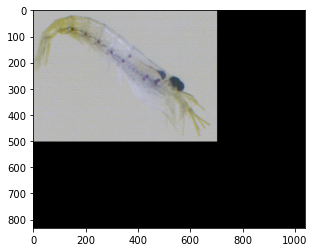

In [9]:
plt.imshow(one_image.raster)

## Masking the image background (one image)

In [10]:
mask = np.zeros_like(one_image.raster, dtype=bool)

imw = one_image.image_width.values
iml = one_image.image_length.values

mask[0:iml, 0:imw, :] = True

mask_da = xr.DataArray(mask, dims=["y", "x", "channel"])

In [11]:
one_image['raster_white_bg'] = one_image.raster.where(mask_da).fillna(255.0).astype(int)

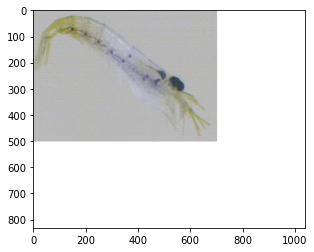

In [12]:
plt.imshow(one_image.raster_white_bg)